# PyTorch Conditional GAN

This initial phase of HW 2 involves extending our PyTorch GAN into a conditional model.  The following steps walk you through building a very simple cGAN based on densely-connected neural layers, in which much of the code is provided.  It will be very similar to our in-class worksheets, so the primary focus will be to practice with embedding layers and passing in labels for conditional models.

## Setup and data loading

We will import torch and the MNIST data set.  Notably, this technique will use a custom transformer versus our previous example.  It demonstrates the Compose() function which allows incorporating normalization of input data.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

batch_size = 256
data_loader = DataLoader(datasets.MNIST('./data', download=True, transform=transform), shuffle=True, batch_size=64)

## Discriminator and Generator Definitions

These models will be similar to our previous PyTorch worksheet.  However, for simplicity, we will use only densely-connected layers, called Linear() layers in PyTorch.  When we looked at a cGAN example in tensorflow, we used convolutional layers and reshaped the embeddings to be combined with the noise and fed into the network.  Here, we'll look at a different approach for passing in labels: simply append the embedding data onto the image vector.

In the below models, you can define a small Embedding layer of 10 dimensions as well as a sequential set of layers run through leaky ReLU and dropout functions: `nn.Embedding(10,10)` defines an embedding layer for 10 labels that contains 10 dimensions.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define an embedding layer here which can be combined into the sequential part of the model during forward()
        self.embedding_layer = nn.Embedding(10, 10)
        
        # The sequential part of the model is given below, using just densely-connected layers
        # The initial 794 inputs accounts for the 784 pixels of each image and 10 concatenated embedding dimensions
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        # update the forward operation

        # First, reshape the input image `x` into a flat list of 784 values
        # In PyTorch, this is done via the .view() function
        # You need a reshaped (.view()) tensor matching the number of input images (x.size(0)) by the desired size (784)
        x = x.view(x.size(0), 784)
        
        # Second, call your embedding layer on the input `labels` tensor and save the result
        embedded_labels = self.embedding_layer(labels)

        # Third, concatenate the reshaped `x` tensor and the embedded `labels` tensor along the feature dimension (dimension 0 is # of inputs and dimension 1 is features)
        # torch.cat([t1,t2], <dimension>) is roughly the syntax to achieve this
        x = torch.cat([x, embedded_labels], dim=1)

        # Finally call your model on the concatenated tensor and return the result
        return self.model(x).squeeze() # .squeeze() flattens out single dimensions

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding_layer = nn.Embedding(10, 10)
        
        # TODO: define the generator
        # This model will be very similar to the discriminator above, except:
        # 1. Your input will be # latent dimensions + 10 embedding dimensions;
        #    for simplicity, we'll hardcode 100 latent dimensions
        # 2. We'll go from 110 -> 256 -> 512 -> 1024 and back to 784 (output size of final layer)
        # 3. There is no need for dropout here as gradient saturation is a bigger concern in the discriminator
        # 4. Use nn.Tanh() activation as the last step of the sequential part of the model
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )


    
    def forward(self, z, labels):
        # TODO: define forward() function
        # This function is nearly identical to the one from the discriminator as well:
        # 1. We only have 100 input dimensions not 784
        # 2. After calling self.model() on the concatenated tensor (latent data and labels),
        #    you should reshape the result into a 28x28 image, e.g., generated.view(z.size(0),28,28)
        z = z.view(z.size(0), 100)

        embedded_labels = self.embedding_layer(labels)

        z = torch.cat([z, embedded_labels], dim=1)

        return self.model(z).view(z.size(0), 28, 28)

In [7]:
# Define models and specify loss and optimizers

device = torch.device("cuda") # use "cuda" or "mps" per your platform for graphics acceleration

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

## Training

In this simplified activity, we won't bother wrapping the models in a new GAN model.  Such a technique was useful in tensorflow with keras as we could lock the layer weights for the discriminator in the GAN while still being able to train the discriminator directly by calling it on its own.  In PyTorch, since we are defining a custom training loop, we can work directly with the models and train them only as needed.

In [5]:
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [8]:
num_epochs = 50
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        
        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
        
        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).to(device)
            labels = Variable(torch.LongTensor(np.arange(9))).to(device)
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
    print('Done!')

Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

## Save and Run

After training, you can save your model and view results, generating digits corresponding to your desired labels.

In [10]:
# save
torch.save(generator.state_dict(), 'generator.pt')

(-0.5, 301.5, 301.5, -0.5)

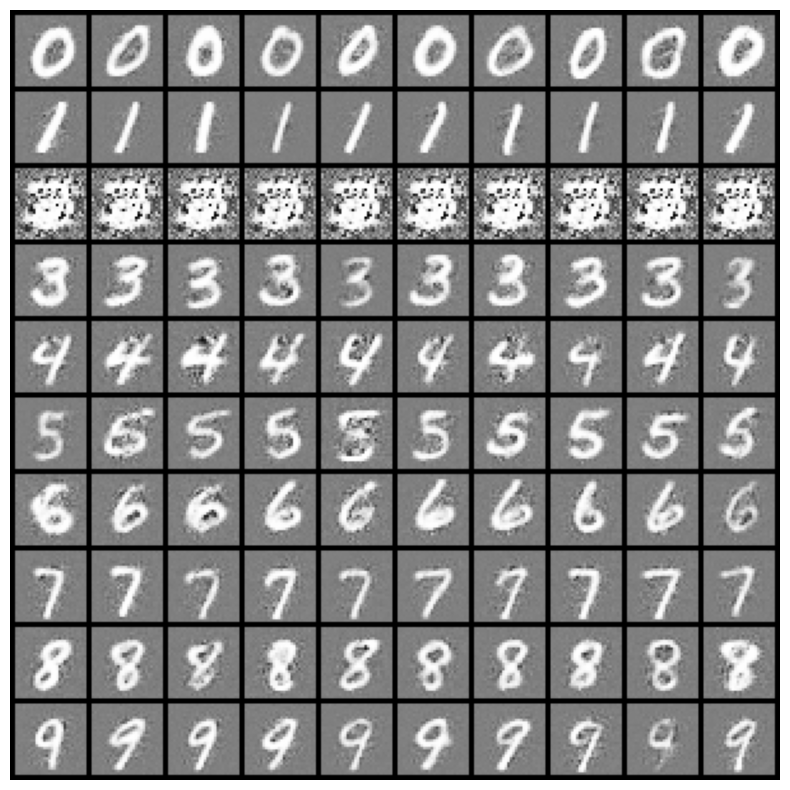

In [11]:
# generate examples to view
%matplotlib inline
import matplotlib.pyplot as plt

z = Variable(torch.randn(100, 100)).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

images = generator(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
plot_data = grid.permute(1,2,0).data
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(plot_data.cpu().detach(), cmap='binary')
ax.axis('off')

In [20]:
# generate according to label
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

generate_digit(generator, 9)

---

The goal of this notebook has mainly been to give you more experience with PyTorch while practicing model definitions and creating a cGAN.  Through these examples of text-directed outputs via label inputs, we can begin to see ties to current image generation models.  In fact, we now have the bulk of the pieces necessary to understand the [latent diffusion model](https://en.wikipedia.org/wiki/Latent_diffusion_model#Architecture) used in the popular [Stable Diffusion](https://en.wikipedia.org/wiki/Stable_Diffusion) text-to-image model we'll at least see in use later; this model consists of a combination of technologies like text embeddings, VAE, and U-Net, which is a convolutional network model for image segmentation which can be constructed of various technologies including the upcoming transformers topic.